In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

# Model

In [2]:
model = ExtraTreesRegressor(random_state=1)

# Loading Data

In [3]:
lycopersicum = pd.read_csv('./input/lycopersicum_kmers.csv')

# Smoothing crossovers
lycopersicum['crossovers'] = lycopersicum['crossovers'].astype(float)
lycopersicum['scrossovers'] = 0 
for i in range (1, len(lycopersicum)):
    if lycopersicum.loc[i-1,'chr'] == lycopersicum.loc[i,'chr']:
        lycopersicum['scrossovers'] = gaussian_filter(lycopersicum['crossovers'], sigma= 3)
        
lycopersicum.head()

,cross,reference,chr,start,end,crossovers,AAA,AAC,AAG,AAT,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,scrossovers
0,lycopersicum_pimpinellifolium,lycopersicum,chr1,0,100000,0.0,5131,1569,1987,3622,...,1777,1910,1054,1213,1916,2815,2175,2456,5659,0.412753
1,lycopersicum_pimpinellifolium,lycopersicum,chr1,100000,200000,0.0,5725,1659,2040,4200,...,1868,2032,819,1146,1876,3503,2030,2404,5689,0.423919
2,lycopersicum_pimpinellifolium,lycopersicum,chr1,200000,300000,1.0,5181,1848,2007,3773,...,1907,2047,980,1070,1961,3330,2039,2373,5368,0.437421
3,lycopersicum_pimpinellifolium,lycopersicum,chr1,300000,400000,1.0,5201,1733,2091,3889,...,1848,2029,904,1066,2039,3417,2071,2383,5501,0.442235
4,lycopersicum_pimpinellifolium,lycopersicum,chr1,400000,500000,1.0,5715,1862,1882,4043,...,2006,2032,871,1039,1791,3345,2244,2294,5618,0.433930


In [4]:
pimpinellifolium = pd.read_csv('./input/pimpinellifolium_kmers.csv')

# Smoothing crossovers
pimpinellifolium['crossovers'] = pimpinellifolium['crossovers'].astype(float)
pimpinellifolium['scrossovers'] = 0 
for i in range (1, len(pimpinellifolium)):
    if pimpinellifolium.loc[i-1,'chr'] == pimpinellifolium.loc[i,'chr']:
        pimpinellifolium['scrossovers'] = gaussian_filter(pimpinellifolium['crossovers'], sigma= 3)
        
pimpinellifolium.head()

,cross,reference,chr,start,end,crossovers,AAA,AAC,AAG,AAT,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,scrossovers
0,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,0,100000,0.0,5213,1597,1969,3659,...,1790,1909,1033,1200,1921,2852,2177,2438,5676,0.240383
1,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,100000,200000,0.0,5319,1676,2115,3751,...,1882,1983,904,1233,1851,3110,2003,2392,5021,0.248206
2,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,200000,300000,1.0,4196,1547,1977,2831,...,1582,1673,1200,1448,1906,2203,2097,2482,5415,0.260576
3,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,300000,400000,0.0,5595,1641,1947,4143,...,1804,2021,817,960,1937,3793,1995,2360,5920,0.273225
4,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,400000,500000,0.0,5430,1850,2017,3861,...,1911,2018,938,1070,1889,3252,2115,2275,5508,0.283863


# Reverse-complements count

In [5]:
df_original = lycopersicum
df_new = df_original[['cross','reference','chr', 'start', 'end','crossovers','scrossovers']].copy()

# List of complementary trimers
complementaries = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

# Set to track processed trimers
processed = set()

# Iterate over the columns of the original DataFrame
for column in df_original.columns[9:-1]:  # Starts from where kmers start
    trimer = column[:3]  # Get the current trimer (e.g., 'AAA')
    
    # Avoid processing the same trimer more than once
    if trimer not in processed:
        complementary = ''.join([complementaries[base] for base in reversed(trimer)])  # Get the complementary trimer (e.g., 'TTT')
        
        # Sum the corresponding columns and add a new column to the new DataFrame
        df_new[trimer + '_' + complementary] = df_original[trimer] + df_original[complementary]
        
        # Add the trimer and its complementary to the set of processed trimers
        processed.add(trimer)
        processed.add(complementary)
        
lycopersicum2 = df_new

In [6]:
lycopersicum2.head()

,cross,reference,chr,start,end,crossovers,scrossovers,AAT_ATT,ACA_TGT,ACC_GGT,...,GAA_TTC,GAC_GTC,GCA_TGC,GCC_GGC,GGA_TCC,GTA_TAC,GTT_AAC,TAA_TTA,TCA_TGA,TTT_AAA
0,lycopersicum_pimpinellifolium,lycopersicum,chr1,0,100000,0.0,0.412753,7568,3819,1844,...,4060,2062,2138,1120,2238,2486,3101,5684,4066,10790
1,lycopersicum_pimpinellifolium,lycopersicum,chr1,100000,200000,0.0,0.423919,8318,3774,1539,...,4179,1499,1592,861,1966,2530,3443,6986,4115,11414
2,lycopersicum_pimpinellifolium,lycopersicum,chr1,200000,300000,1.0,0.437421,7701,3911,1597,...,4123,1535,1950,828,2037,2651,3615,6559,4143,10549
3,lycopersicum_pimpinellifolium,lycopersicum,chr1,300000,400000,1.0,0.442235,7897,3977,1714,...,4192,1490,1886,747,1916,2682,3540,6740,4105,10702
4,lycopersicum_pimpinellifolium,lycopersicum,chr1,400000,500000,1.0,0.433930,8123,3755,1674,...,4223,1444,1731,771,1971,2573,3527,6707,4175,11333


In [7]:
df_original = pimpinellifolium
df_new = df_original[['cross','reference','chr', 'start', 'end','crossovers','scrossovers']].copy()

# List of complementary trimers
complementaries = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

# Set to track processed trimers
processed = set()

# Iterate over the columns of the original DataFrame
for column in df_original.columns[9:-1]:  # Starts from where kmers start
    trimer = column[:3]  # Get the current trimer (e.g., 'AAA')
    
    # Avoid processing the same trimer more than once
    if trimer not in processed:
        complementary = ''.join([complementaries[base] for base in reversed(trimer)])  # Get the complementary trimer (e.g., 'TTT')
        
        # Sum the corresponding columns and add a new column to the new DataFrame
        df_new[trimer + '_' + complementary] = df_original[trimer] + df_original[complementary]
        
        # Add the trimer and its complementary to the set of processed trimers
        processed.add(trimer)
        processed.add(complementary)
        
pimpinellifolium2 = df_new

In [8]:
pimpinellifolium2.head()

,cross,reference,chr,start,end,crossovers,scrossovers,AAT_ATT,ACA_TGT,ACC_GGT,...,GAA_TTC,GAC_GTC,GCA_TGC,GCC_GGC,GGA_TCC,GTA_TAC,GTT_AAC,TAA_TTA,TCA_TGA,TTT_AAA
0,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,0,100000,0.0,0.240383,7606,3834,1829,...,4055,1998,2092,1137,2221,2481,3123,5771,4049,10889
1,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,100000,200000,0.0,0.248206,7397,3679,1721,...,4223,1759,1757,1166,2205,2414,3518,6160,4016,10340
2,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,200000,300000,1.0,0.260576,6317,3586,2192,...,3908,2733,2432,1524,2633,2363,3076,4322,4003,9611
3,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,300000,400000,0.0,0.273225,8472,4136,1526,...,3982,1400,1643,707,1757,2556,3436,7432,4010,11515
4,lycopersicum_pimpinellifolium,pimpinellifolium,chr1,400000,500000,0.0,0.283863,7707,3916,1749,...,4247,1521,1917,807,1971,2660,3500,6405,4129,10938


# Model training

In [9]:
# Training model with lycopersicum reverse complementary k-mers
df = lycopersicum2
X_train = df.drop(['cross','reference','chr', 'start', 'end','crossovers','scrossovers'], axis=1)
y_train = df[['crossovers']]
model.fit(X_train, y_train)

ExtraTreesRegressor(random_state=1)

# Chromosome Split

In [10]:
# Objects with chromosome data from pimpinellifolium
df = pimpinellifolium2
chr1 = df[df['chr']== 'chr1']
chr2 = df[df['chr']== 'chr2']
chr3 = df[df['chr']== 'chr3']
chr4 = df[df['chr']== 'chr4']
chr5 = df[df['chr']== 'chr5']
chr6 = df[df['chr']== 'chr6']
chr7 = df[df['chr']== 'chr7']
chr8 = df[df['chr']== 'chr8']
chr9 = df[df['chr']== 'chr9']
chr10 = df[df['chr']== 'chr10']
chr11 = df[df['chr']== 'chr11']
chr12 = df[df['chr']== 'chr12']

# Function to make predictions and graphs

The model is trained with the information of all chromosomes except the information of the chromosome to be predicted.

In [11]:
def plot_chromosome_results(chr_number):
    # Replace  with 'chr{chr_number}' 
    chr_data = globals()[f'chr{chr_number}']

    # MODEL PREDICTIONS
    model_preds = model.predict(chr_data.drop(['cross','reference','chr', 'start', 'end','crossovers','scrossovers'], axis=1))
    
    #SMOOTHING
    model_preds = pd.DataFrame(model_preds, columns=['model_preds']) 
    model_spreds = gaussian_filter(model_preds['model_preds'], sigma= 3)
        
    #CORRELATIONS BY QUARTILES
    c_q1 = int(len(chr_data)*0.25)
    c_q2 = int(len(chr_data)*0.50)
    c_q3 = int(len(chr_data)*0.75)
    
    rq1 = chr_data['scrossovers'].iloc[0:c_q1]
    rq2 = chr_data['scrossovers'].iloc[c_q1:c_q2]
    rq3 = chr_data['scrossovers'].iloc[c_q2:c_q3]
    rq4 = chr_data['scrossovers'].iloc[c_q3:int(len(chr_data))]

    pq1 = model_spreds[0:c_q1]
    pq2 = model_spreds[c_q1:c_q2]
    pq3 = model_spreds[c_q2:c_q3]
    pq4 = model_spreds[c_q3:int(len(chr_data))]

    corr_q1 = np.corrcoef(rq1, pq1)[0, 1]
    corr_q2 = np.corrcoef(rq2, pq2)[0, 1]
    corr_q3 = np.corrcoef(rq3, pq3)[0, 1]
    corr_q4 = np.corrcoef(rq4, pq4)[0, 1]
    
    globals()[f'corr_q1_chr{chr_number}'] = corr_q1
    globals()[f'corr_q2_chr{chr_number}'] = corr_q2
    globals()[f'corr_q3_chr{chr_number}'] = corr_q3
    globals()[f'corr_q4_chr{chr_number}'] = corr_q4
     
    # PLOTTING RESULTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), gridspec_kw={'width_ratios': [10, 3]})

    # Line plot and correlation plot
    ax1.plot(chr_data.end, chr_data.scrossovers, label='Crossovers')
    ax1.plot(chr_data.end, model_spreds, label='Prediction', color='green')
    ax1.set_title(f'S. pimpinellifolium Chromosome {chr_number}', fontsize=20)
    ax1.set_xlabel('Chromosome position (Mb)', fontsize=15)
    ax1.set_ylabel('Crossovers (100kb)', fontsize=14)
    ax1.legend(loc='upper right', fontsize=12)
    ticks = ax1.get_xticks() / 1000000
    ax1.set_xticklabels(ticks)
        
    chr_len = chr_data["end"].iloc[-1]
    q1 =round(chr_len * 0.25 / 100000) * 100000
    q2 =round(chr_len* 0.50 / 100000) * 100000
    q3 =round(chr_len * 0.75 / 100000) * 100000

    ax1.axvline(x=q1, color='gray', linestyle='-')
    ax1.axvline(x=q2, color='gray', linestyle='--')
    ax1.axvline(x=q3, color='gray', linestyle='-')

    # Scatter plot
    scatter = ax2.scatter(chr_data.scrossovers, model_spreds, c='skyblue', edgecolors='black', linewidth= 0.3)
    ax2.set_title('Crossovers  vs. Prediction', fontsize=15)
    ax2.set_xlabel('Crossovers ', fontsize=15)
    ax2.set_ylabel('Prediction', fontsize=15)

    # Calculate correlation coefficient, coefficient of determination, and Mean Squared Error
    corr_chr = np.corrcoef(chr_data.scrossovers, model_spreds)[0, 1]
    r2_chr = r2_score(chr_data.scrossovers, model_spreds)
    mse_chr = mean_squared_error(chr_data.scrossovers, model_spreds)

    # Calculate the aspect ratio based on the plot heights
    h1 = ax1.get_ylim()
    h2 = ax2.get_ylim()
    aspect_ratio = max(h1[1] - h1[0], h2[1] - h2[0]) / (max(h1[1], h2[1]) - min(h1[0], h2[0]))

    # Set the aspect ratio for the scatter plot only if it doesn't distort the square shape
    if aspect_ratio < 1:
        ax2.set_aspect('equal')

    # Display correlation coefficient, coefficient of determination, and Mean Squared Error as plain text
    globals()[f'corr_chr{chr_number}'] = corr_chr
    globals()[f'r2_chr{chr_number}'] = r2_chr
    globals()[f'mse_chr{chr_number}'] = mse_chr

    textstr = f'Correlation: {corr_chr:.3f}\nR-squared: {r2_chr:.3f}\nMSE: {mse_chr:.3f}'
    ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

    # Adjustments to align the heights of the two plots
    max_height = max(h1[1], h2[1])
    ax1.set_ylim([h1[0], max_height])
    ax2.set_ylim([h2[0], max_height])

    # Reduce the separation between the plots
    plt.subplots_adjust(wspace=0.13)
    plt.show()

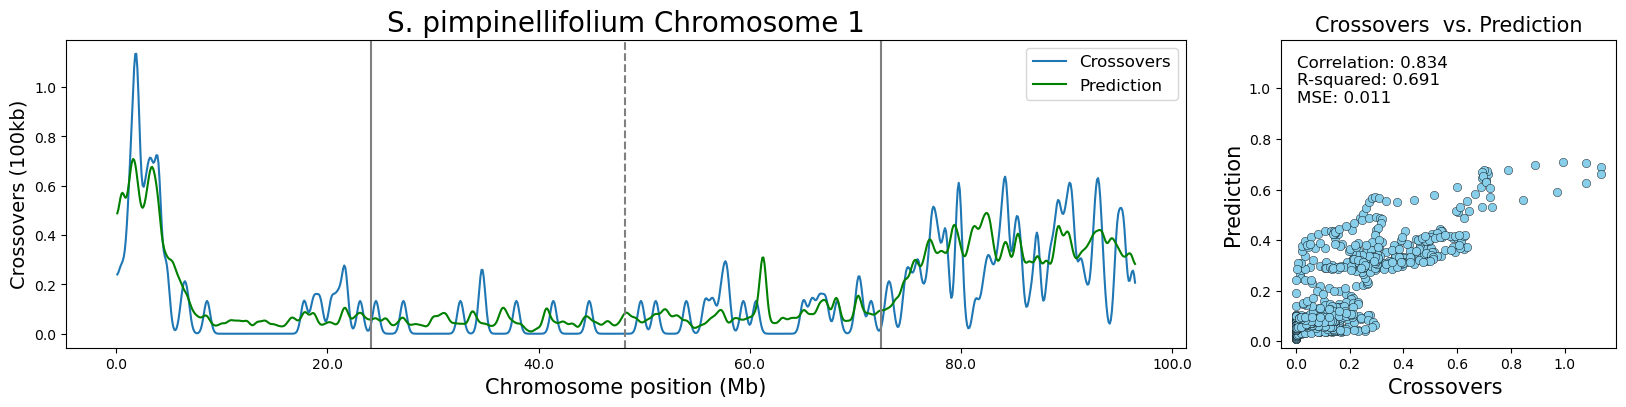

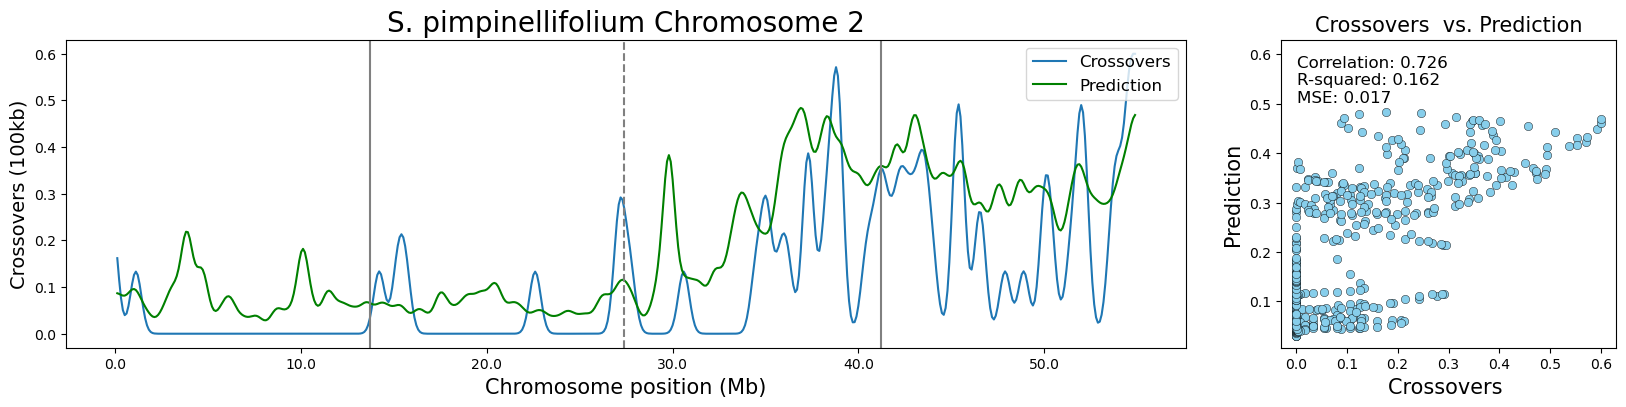

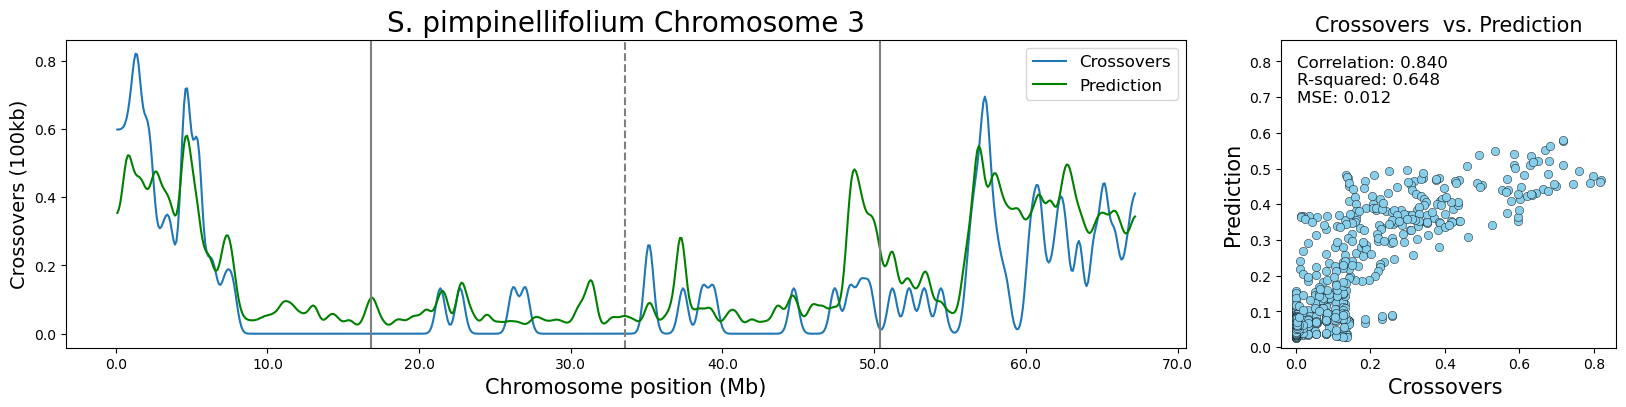

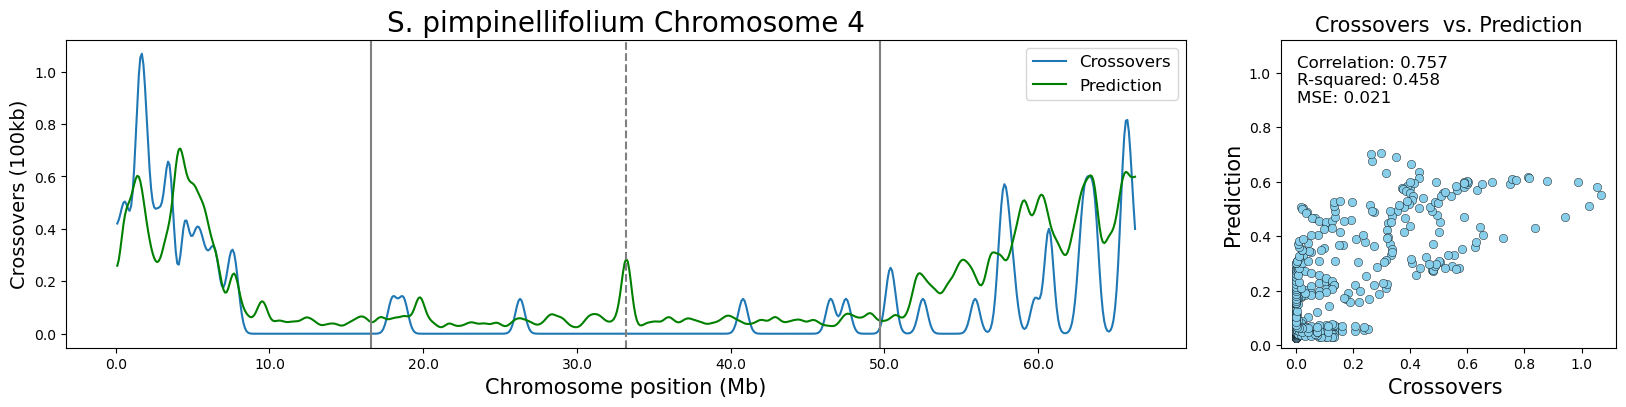

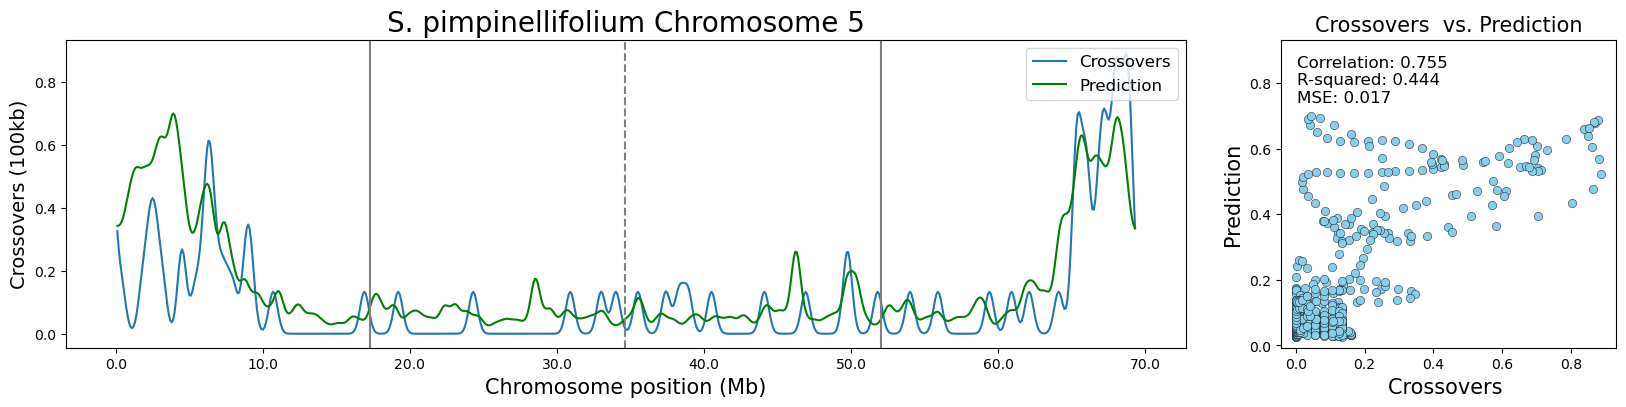

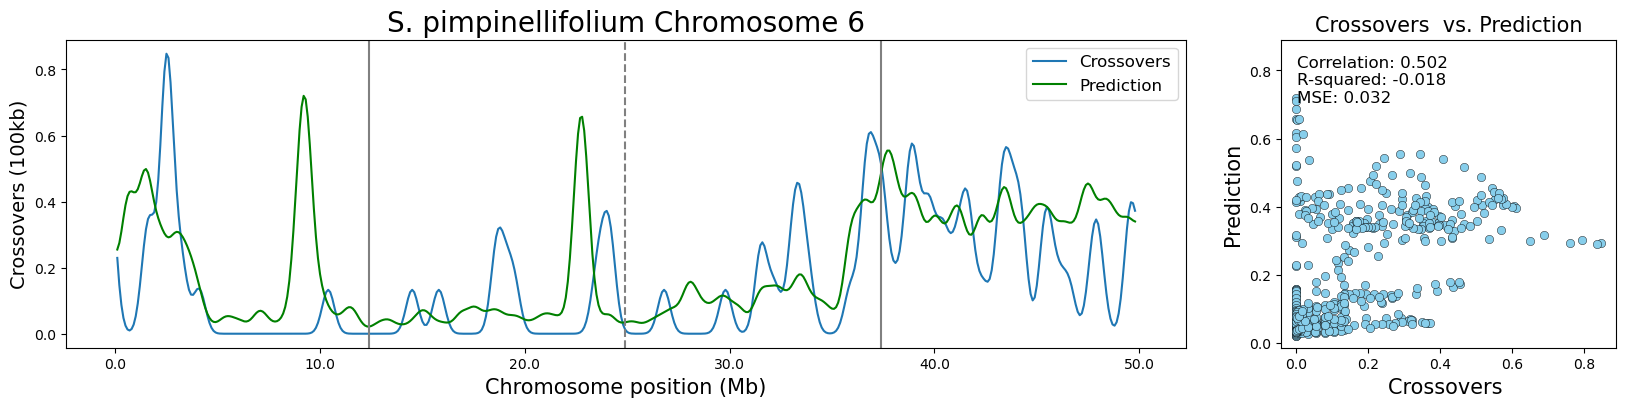

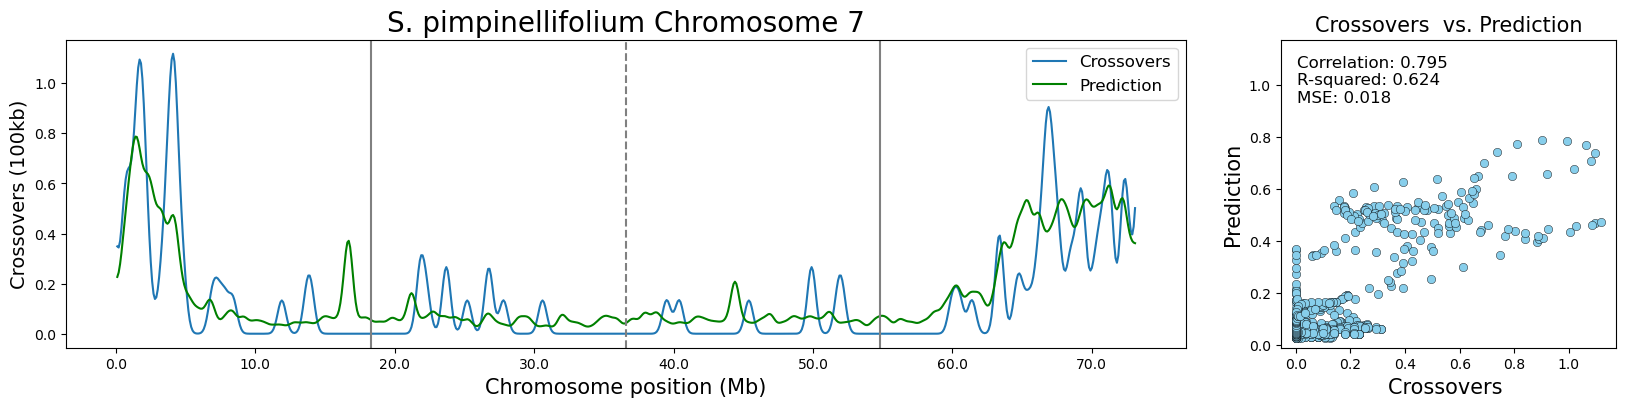

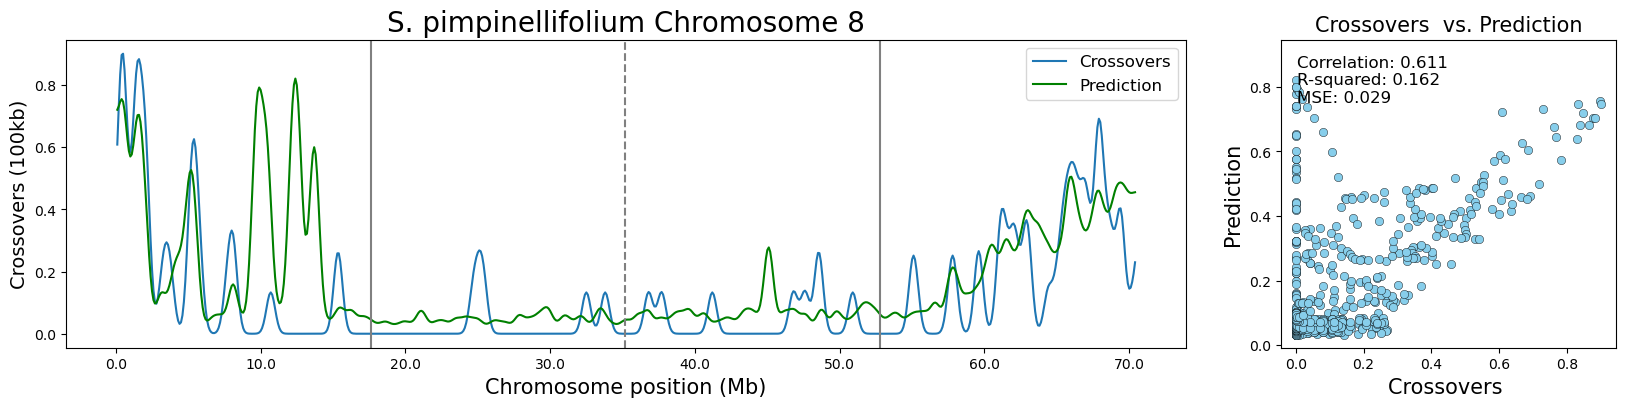

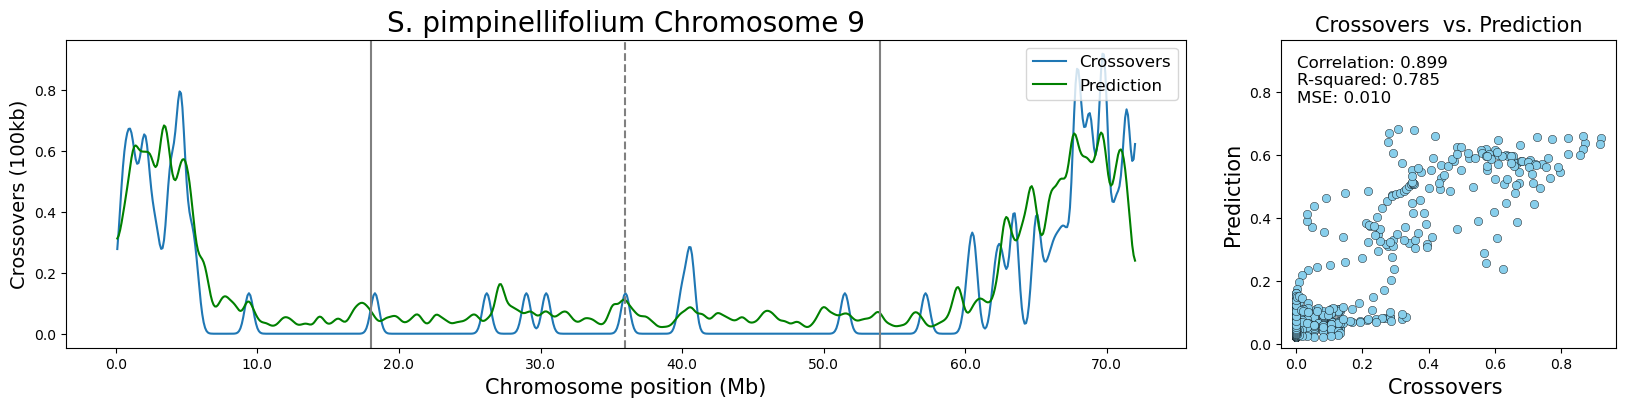

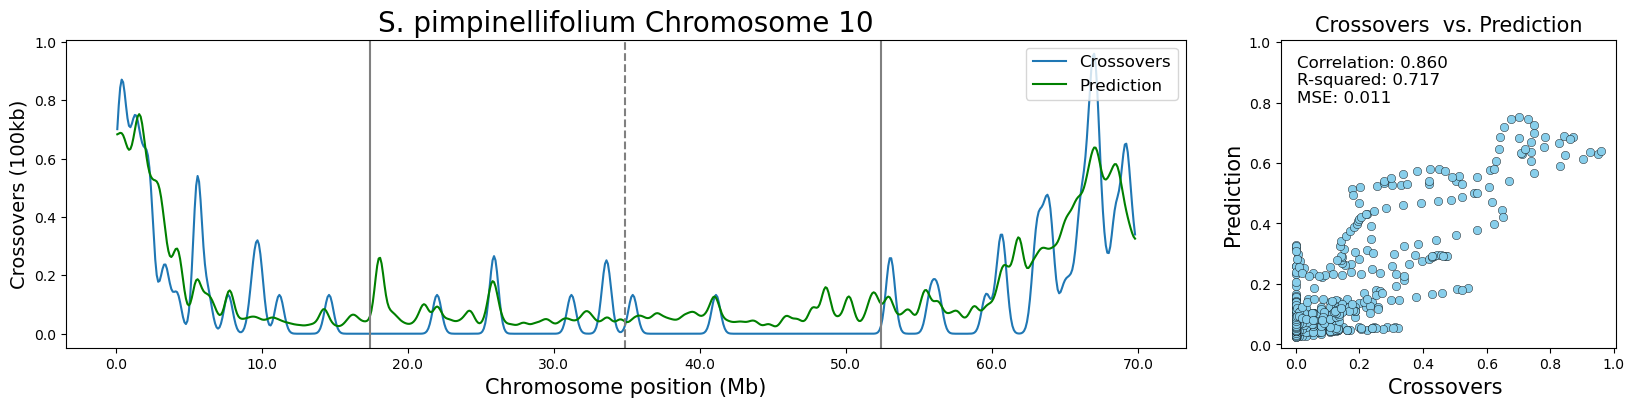

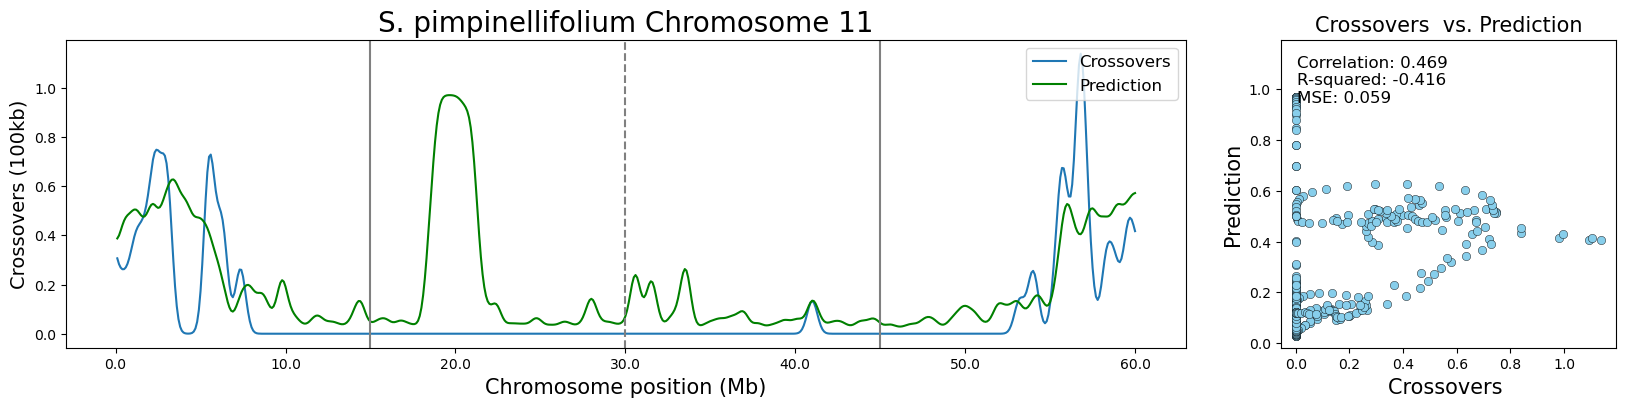

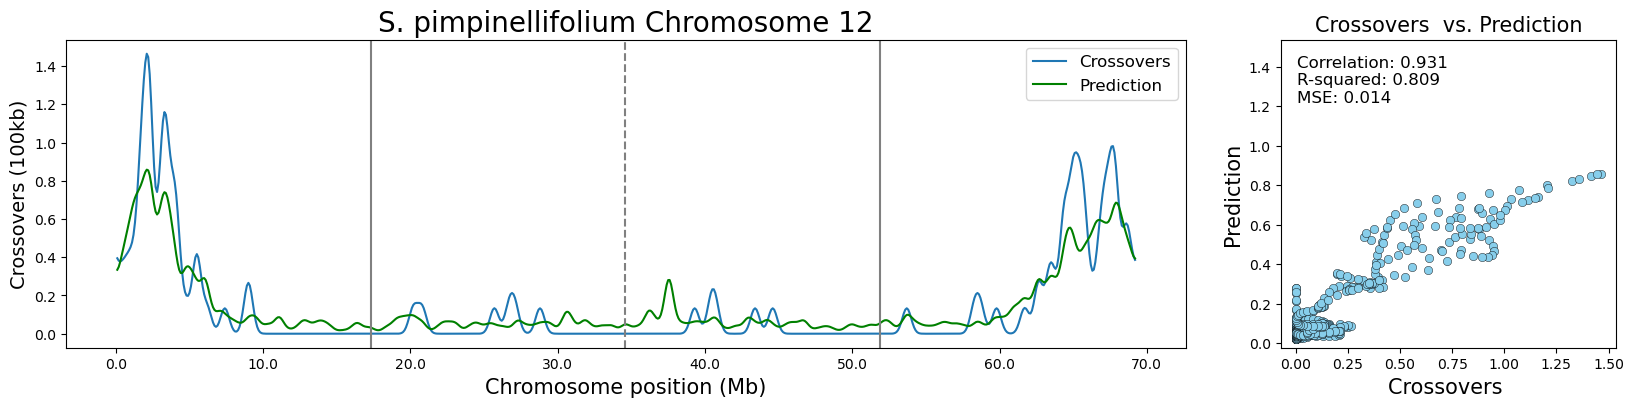

In [12]:
# Predictions and graphs for all chromosomes
for chr_number in range(1, 13):
    plot_chromosome_results(chr_number)
    plt.show()

# Data compilation

In [13]:
corr = pd.DataFrame({'corr':[corr_chr1, corr_chr2, corr_chr3, corr_chr4, corr_chr5, corr_chr6,corr_chr7, corr_chr8, corr_chr9, corr_chr10, corr_chr11, corr_chr12]})
r2 = pd.DataFrame({'R^2':[r2_chr1, r2_chr2, r2_chr3, r2_chr4, r2_chr5, r2_chr6, r2_chr7, r2_chr8, r2_chr9, r2_chr10, r2_chr11, r2_chr12]})
mse = pd.DataFrame({'MSE':[mse_chr1, mse_chr2, mse_chr3, mse_chr4, mse_chr5, mse_chr6, mse_chr7, mse_chr8, mse_chr9, mse_chr10, mse_chr11, mse_chr12]})
index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12']})
table = pd.concat([index, corr, r2, mse], axis=1)
table

,chr,corr,R^2,MSE
0,chr1,0.833645,0.690707,0.010967
1,chr2,0.726181,0.162057,0.016869
2,chr3,0.840489,0.648422,0.011569
3,chr4,0.757267,0.457950,0.020645
4,chr5,0.754659,0.443743,0.017346
5,chr6,0.502275,-0.018375,0.031908
6,chr7,0.795009,0.623518,0.018091
7,chr8,0.611190,0.161552,0.028634
8,chr9,0.898857,0.785233,0.009839
9,chr10,0.860414,0.717406,0.010688


# Correlations between predictions and original values by chromosome quartiles

In [14]:
corr_q1 = pd.DataFrame({'Q1':[corr_q1_chr1,corr_q1_chr2,corr_q1_chr3,corr_q1_chr4,corr_q1_chr5,corr_q1_chr6,corr_q1_chr7,corr_q1_chr8,corr_q1_chr9,corr_q1_chr10,corr_q1_chr11,corr_q1_chr12]})
corr_q2 = pd.DataFrame({'Q2':[corr_q2_chr1,corr_q2_chr2,corr_q2_chr3,corr_q2_chr4,corr_q2_chr5,corr_q2_chr6,corr_q2_chr7,corr_q2_chr8,corr_q2_chr9,corr_q2_chr10,corr_q2_chr11,corr_q2_chr12]})
corr_q3 = pd.DataFrame({'Q3':[corr_q3_chr1,corr_q3_chr2,corr_q3_chr3,corr_q3_chr4,corr_q3_chr5,corr_q3_chr6,corr_q3_chr7,corr_q3_chr8,corr_q3_chr9,corr_q3_chr10,corr_q3_chr11,corr_q3_chr12]})
corr_q4 = pd.DataFrame({'Q4':[corr_q4_chr1,corr_q4_chr2,corr_q4_chr3,corr_q4_chr4,corr_q4_chr5,corr_q4_chr6,corr_q4_chr7,corr_q4_chr8,corr_q4_chr9,corr_q4_chr10,corr_q4_chr11,corr_q4_chr12]})

index = pd.DataFrame({'chr':['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12']})
q_corr = pd.concat([index, corr_q1, corr_q2, corr_q3, corr_q4], axis=1)
q_corr_styled = q_corr.style.background_gradient(cmap="PRGn", vmin=-1, vmax=1)
q_corr_styled.set_table_styles([{'selector': 'th',
                                'props': [('text-align', 'center')]}])
q_corr_styled 

,chr,Q1,Q2,Q3,Q4
0,chr1,0.899249,0.031654,0.129309,0.408841
1,chr2,0.025511,0.198302,0.575959,0.707181
2,chr3,0.943791,0.225176,0.503603,0.739849
3,chr4,0.821034,0.047694,-0.127685,0.607710
4,chr5,0.561554,-0.163996,0.180181,0.919748
5,chr6,0.328755,-0.129540,0.779761,0.101861
6,chr7,0.804822,0.162445,-0.203361,0.776412
7,chr8,0.420431,0.004006,-0.232999,0.743905
8,chr9,0.920536,0.136266,0.487363,0.843428
9,chr10,0.883893,0.236632,0.146775,0.805630


# Save model performance metrics

In [15]:
table.to_csv('./output/performance_model_trained_in_lycopersicum_to_predict_in_pimpinellifolium_kmers.csv', index = None)